In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Reading the file 
df = pd.read_csv('amazon_alexa.tsv',sep = '\t')

In [3]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [9]:
X_initial= df.iloc[:,:-1]
y = df.iloc[:,-1]

In [10]:

#Drop the date column 
X_initial.drop(columns=['date'],inplace=True)
X_initial.head()

,rating,variation,verified_reviews
0,5,Charcoal Fabric,Love my Echo!
1,5,Charcoal Fabric,Loved it!
2,4,Walnut Finish,"Sometimes while playing a game, you can answer..."
3,5,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...
4,5,Charcoal Fabric,Music


In [6]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: feedback, dtype: int64

In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus=[]
for i in range(0,3150):
    review = re.sub('[^a-zA-Z]', ' ', df['verified_reviews'][i] )
    review=review.lower()
    review=review.split()
    ps=PorterStemmer()
    review=[ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review=' '.join(review)
    corpus.append(review)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_features=1500)
X=cv.fit_transform(corpus).toarray()
y=df.iloc[:,4].values

In [15]:
X[1:5]
X=pd.DataFrame(X)

print(X.shape)
X.head()

(3150, 1500)


,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
#Append the original X_initial and new X which are the numerical features from the coprus
X_final=pd.concat([X_initial,X],axis=1) #Axis =1 means concatinating along the columns 
X_final.head()

,rating,variation,verified_reviews,0,1,2,3,4,5,6,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,5,Charcoal Fabric,Love my Echo!,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,Charcoal Fabric,Loved it!,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,Walnut Finish,"Sometimes while playing a game, you can answer...",0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,5,Charcoal Fabric,Music,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
#We see that X_final has text features like variation and verified_reviews which should be dropped.
X_final.drop(columns=['variation','verified_reviews'],inplace=True)
#Run the drop only once after you concat. If you run multiple times you will get an error as the columns are already dropped.
X_final.head()
#X_final is the final X which we need to train. 

,rating,0,1,2,3,4,5,6,7,8,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [26]:
#!pip install xgboost

In [25]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


In [29]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [2,3, 4, 5],
        'learning_rate':[0.0001,0.001,0.01,0.1,0.2,0.3],
        'n_estimators' :[91,92,93,94,95,96,97,98,100]
        }

In [27]:
xgb = XGBClassifier( objective='binary:logistic',
                    silent=True, nthread=1)

In [30]:
folds = 10
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', 
                                   n_jobs=-1, cv=skf.split(X,y), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_final, y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  5.0min finished



 Time taken: 0 hours 5 minutes and 17.5 seconds.


In [31]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)



 All results:
{'mean_fit_time': array([21.34468286, 19.96853423, 18.57822087, 22.60440497, 23.58533051]), 'std_fit_time': array([2.08897122, 0.78143339, 0.88818333, 0.66882119, 1.00405838]), 'mean_score_time': array([0.06874204, 0.07292223, 0.07041411, 0.07525756, 0.07510564]), 'std_score_time': array([0.0092339 , 0.01191738, 0.01378527, 0.01326331, 0.00729717]), 'param_subsample': masked_array(data=[0.6, 1.0, 0.8, 1.0, 1.0],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[95, 92, 91, 94, 94],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[10, 10, 10, 10, 10],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[5, 4, 4, 3, 4],
             mask=[False, False, False, False, False],
       fill_value

C:\Users\Phanindra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Phanindra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Phanindra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Phanindra\Anaconda3\lib\site-packa

In [32]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_final,y,test_size=0.3,random_state=23)

In [33]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

C:\Users\Phanindra\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [34]:
y_pred = classifier.predict(X_test)

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [36]:
cm

array([[ 71,   3],
       [  1, 870]], dtype=int64)

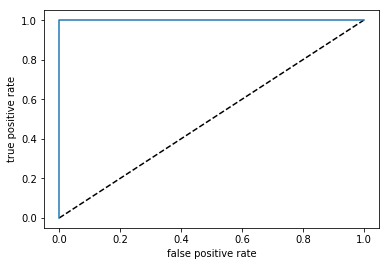

In [37]:
from sklearn.metrics import roc_curve
y_pred_prob = classifier.predict_proba(X_test)[:,-1]
fpr,tpr,thresholds = roc_curve(y_test,y_pred_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr,label='Logistic Regression')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [38]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score



clf = LogisticRegression(class_weight="balanced")
clf.fit(X_train, y_train)
THRESHOLD = 0.84
preds = np.where(clf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

df_results = pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

C:\Users\Phanindra\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [39]:
df_results

,0
accuracy,0.960847
recall,0.957520
precision,1.000000
roc_auc_score,0.978760
